## (Exercise) 클릭스트림 데이터를 사용한 성별 예측모형 개발
<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

In [2]:
# 이 셀의 코드는 수정하지 마세요 !

df_train = pd.read_csv('data_train_6964.csv', encoding='cp949')
df_test = pd.read_csv('data_test_6964.csv', encoding='cp949')
df_real = pd.read_csv('data_test_y.csv', usecols=[1])

In [3]:
# 이 셀의 코드는 수정하지 마세요 !

X_train = df_train.drop(['CUS_ID', 'GENDER'], axis=1)
y_train = df_train['GENDER']
X_test = df_test.drop(['CUS_ID'], axis=1)
y_test = df_real['GENDER']

In [4]:
# 이 셀의 코드는 수정하지 마세요 !

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

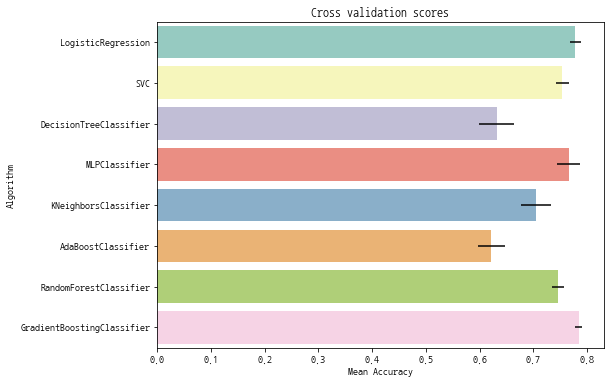

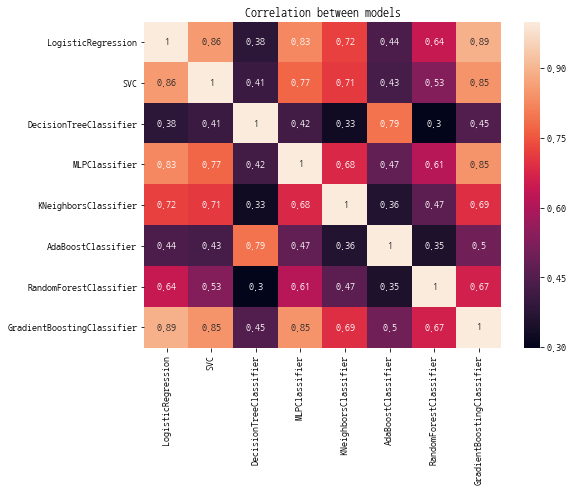

CPU times: user 45.7 s, sys: 2min 26s, total: 3min 12s
Wall time: 22.7 s


In [5]:
%%time
# 이 셀의 코드는 수정하지 마세요 !

clfs = []
LR=LogisticRegression(random_state=0); clfs.append(LR)
SVM=SVC(random_state=0, probability=True); clfs.append(SVM)
DT=DecisionTreeClassifier(random_state=0); clfs.append(DT)
NN=MLPClassifier(random_state=0); clfs.append(NN)
KNN=KNeighborsClassifier(); clfs.append(KNN)
ADB=AdaBoostClassifier(DecisionTreeClassifier(random_state=0),random_state=0); clfs.append(ADB)
RF=RandomForestClassifier(random_state=0); clfs.append(RF)
GBM=GradientBoostingClassifier(random_state=0); clfs.append(GBM)

cv_results = []
pred_results = []
for clf in clfs :
    cv_results.append(cross_val_score(clf, X_train, y_train, scoring="roc_auc", cv=5, n_jobs=-1))
    clf.fit(X_train, y_train)
    pred_results.append(pd.Series(clf.predict_proba(X_test)[:,1], name=type(clf).__name__))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({"CrossValMeans":cv_means, "CrossValerrors": cv_std, 
                       "Algorithm": [type(i).__name__ for i in clfs]})
ensemble_results = pd.concat(pred_results, axis=1)

plt.figure(figsize = (8,6))
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g.set_title("Cross validation scores")
plt.show()

plt.figure(figsize = (8,6))
g = sns.heatmap(ensemble_results.corr(),annot=True)
g.set_title("Correlation between models")
plt.show()

<font color = "#CC3D3D">
### Ensemble Learning을 통해 가장 성능이 우수한 예측모형을 만드시오.
<p>
- 위 모형 중에서 적절한 모형 선택 (성능 및 독립성 고려)
- 다양한 앙상블 방법 적용 

*평가척도가 ROC_AUC일 때, vecstack 패키지를 이용하여 stacking하는 법*

In [6]:
from vecstack import stacking
from sklearn.metrics import accuracy_score, roc_auc_score

models = clfs
S_train, S_test = stacking(models,                     # list of models
                           X_train, y_train, X_test,   # data
                           regression=False,           # classification task (if you need 
                                                       #     regression - set to True)
                           needs_proba=True,           # predict class labels (if you need 
                                                       #     probabilities - set to True) 
                           metric=None,                # metric: callable
                           n_folds=4,                  # number of folds
                           stratified=True,            # stratified split for folds
                           shuffle=True,               # shuffle the data
                           random_state=0,             # ensure reproducibility
                           verbose=0)                  # print all info
meta_model = LR.fit(S_train, y_train)
roc_auc_score(y_test, meta_model.predict_proba(S_test)[:,1])

0.7683726149037102

*모형을 다양하게 조합하여 stacking한 후 최적의 조합 찾기*

In [7]:
%%time
from itertools import combinations

results = []

for i in range(6,8):
    for models in combinations(clfs, i):
        S_train, S_test = stacking(models,             # list of models
                           X_train, y_train, X_test,   # data
                           regression=False,           # classification task (if you need 
                                                       #     regression - set to True)
                           needs_proba=True,           # predict class labels (if you need 
                                                       #     probabilities - set to True) 
                           metric=None,                # metric: callable
                           n_folds=4,                  # number of folds
                           stratified=True,            # stratified split for folds
                           shuffle=True,               # shuffle the data
                           random_state=0,             # ensure reproducibility
                           verbose=0)                  # print all info
        meta_model = LR.fit(S_train, y_train)
        combi = [type(i).__name__ for i in models]
        score = roc_auc_score(y_test, meta_model.predict_proba(S_test)[:,1])
        results.append((score, combi))

print(max(results))

(0.7687967364118381, ['LogisticRegression', 'SVC', 'DecisionTreeClassifier', 'MLPClassifier', 'KNeighborsClassifier', 'GradientBoostingClassifier'])
CPU times: user 55min 52s, sys: 2h 54min 43s, total: 3h 50min 36s
Wall time: 8min 7s


*3-layer stacking 모형 만들기*

In [8]:
# level-1

models = clfs
S_train, S_test = stacking(models,                     # list of models
                           X_train, y_train, X_test,   # data
                           regression=False,           # classification task (if you need 
                                                       #     regression - set to True)
                           needs_proba=True,           # predict class labels (if you need 
                                                       #     probabilities - set to True) 
                           metric=None,                # metric: callable
                           n_folds=4,                  # number of folds
                           stratified=True,            # stratified split for folds
                           shuffle=True,               # shuffle the data
                           random_state=0,             # ensure reproducibility
                           verbose=0)                  # print all info

In [9]:
# level-2

meta_models = [LR, SVM, GBM]
meta_pred = []
meta_auc = []
for model in meta_models:
    pred = model.fit(S_train, y_train).predict_proba(S_test)[:,1]
    auc = roc_auc_score(y_test, pred)
    meta_pred.append(pred)
    meta_auc.append(auc)
print(meta_auc)

[0.7683726149037102, 0.7527187061072826, 0.7590352309415431]


In [10]:
# level-3 

final_pred = np.average(meta_pred, weights=(2,0.1,0.1), axis=0)    
print(roc_auc_score(y_test, final_pred))

0.7684424070506174


*모형마다 다른 feature 사용하여 stacking하기*

In [11]:
import random

S_trains = []
S_tests = []

for clf in clfs:
    s = random.sample(range(X_train.shape[1]), 17)
    S_train, S_test = stacking([clf],                   # list of models
                           X_train[:,s], y_train, X_test[:,s],   # data
                           regression=False,           # classification task (if you need 
                                                       #     regression - set to True)
                           needs_proba=True,           # predict class labels (if you need 
                                                       #     probabilities - set to True) 
                           metric=None,                # metric: callable
                           n_folds=4,                  # number of folds
                           stratified=True,            # stratified split for folds
                           shuffle=True,               # shuffle the data
                           random_state=0,             # ensure reproducibility
                           verbose=0)                  # print all info
    S_trains.append(S_train)
    S_tests.append(S_test)

meta_model = LR.fit(np.hstack(S_trains), y_train)
print(roc_auc_score(y_test, meta_model.predict_proba(np.hstack(S_tests))[:,1]))

0.757807828665648
